In [1]:
from detectron2.utils.logger import setup_logger
setup_logger()
import cv2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_dataset", {}, "COCOAnnotations/trainnew.json", "MergeDataset/")
register_coco_instances("test_dataset", {}, "COCOAnnotations/testnew.json", "MergeDataset/")

In [3]:
sample_metadata = MetadataCatalog.get("train_dataset")
dataset_dicts = DatasetCatalog.get("test_dataset")

[03/25 09:34:40 d2.data.datasets.coco]: Loaded 60 images in COCO format from COCOAnnotations/testnew.json


{'file_name': 'MergeDataset/AD3311F3-9517-4CE3-AB1C-6875A68818AE_1_105_c.jpeg', 'height': 1024, 'width': 768, 'image_id': 129, 'annotations': [{'iscrowd': 0, 'bbox': [699.0, 790.0, 52.0, 234.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [567.0, 95.0, 201.0, 189.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [622.0, 224.0, 146.0, 145.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [627.0, 883.0, 74.0, 140.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [327.0, 491.0, 165.0, 164.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [568.0, 154.0, 196.0, 197.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [215.0, 443.0, 145.0, 120.0], 'category_id': 1, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


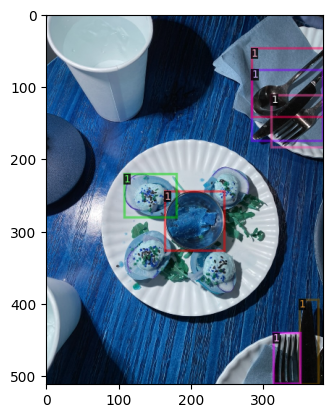

In [4]:
import random
from matplotlib import pyplot as plt


for d in random.sample(dataset_dicts, 1):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = ("test_dataset",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 16
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")# initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 1500   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # 3 classes (Person, Helmet, Car)
cfg.MODEL.DEVICE = 'cuda'
cfg.OUTPUT_DIR = 'saved_models/FasterRCNN/'
cfg.MODEL.BACKBONE.FREEZE_AT = 2

In [6]:
import torch


class Trainer(DefaultTrainer):
    @classmethod
    def build_optimizer(cls, cfg, model):
        """
        Custom function to build the optimizer, allowing us to exclude
        certain parameters from the optimizer (thus freezing them)
        """
        frozen_parameters = set()
        for name, parameter in model.named_parameters():
            if "backbone" in name:  # Freeze layers by adjusting this condition
                frozen_parameters.add(name)
                parameter.requires_grad_(False)

        params = []
        for key, value in model.named_parameters():
            if key not in frozen_parameters and value.requires_grad:
                params.append({"params": [value]})
        optimizer = torch.optim.SGD(params, lr=cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM)
        return optimizer
     

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/25 09:34:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[03/25 09:34:42 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\rs659\Desktop\Object-Detection\wincondaprojenv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/25 09:34:51 d2.utils.events]:  eta: 0:03:44  iter: 19  total_loss: 2.314  loss_cls: 1.529  loss_box_reg: 0.7344  loss_rpn_cls: 0.01497  loss_rpn_loc: 0.0105    time: 0.1907  last_time: 0.2247  data_time: 0.1944  last_data_time: 0.0009   lr: 3.9962e-05  max_mem: 1466M
[03/25 09:34:55 d2.utils.events]:  eta: 0:03:49  iter: 39  total_loss: 1.832  loss_cls: 1.055  loss_box_reg: 0.7573  loss_rpn_cls: 0.005284  loss_rpn_loc: 0.009899    time: 0.1860  last_time: 0.1488  data_time: 0.0015  last_data_time: 0.0008   lr: 7.9922e-05  max_mem: 1466M
[03/25 09:34:58 d2.utils.events]:  eta: 0:03:41  iter: 59  total_loss: 1.439  loss_cls: 0.6817  loss_box_reg: 0.698  loss_rpn_cls: 0.01734  loss_rpn_loc: 0.009125    time: 0.1779  last_time: 0.2486  data_time: 0.0018  last_data_time: 0.0013   lr: 0.00011988  max_mem: 1466M
[03/25 09:35:01 d2.utils.events]:  eta: 0:03:38  iter: 79  total_loss: 1.248  loss_cls: 0.551  loss_box_reg: 0.679  loss_rpn_cls: 0.01049  loss_rpn_loc: 0.006902    time: 0.1759  

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Test model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Create COCO evaluator
evaluator = COCOEvaluator("test_dataset", cfg, False, output_dir="./output/")

# Build test loader
val_loader = build_detection_test_loader(cfg, "test_dataset")

# Perform inference and evaluation
evaluation_results = inference_on_dataset(trainer.model, val_loader, evaluator)

# Print mAP (assuming COCO format)
print("mAP:", evaluation_results['bbox'])


WARNING [03/25 09:38:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/25 09:38:40 d2.data.datasets.coco]: Loaded 60 images in COCO format from COCOAnnotations/testnew.json
[03/25 09:38:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/25 09:38:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/25 09:38:40 d2.data.common]: Serializing 60 elements to byte tensors and concatenating them all ...
[03/25 09:38:40 d2.data.common]: Serialized dataset takes 0.02 MiB
[03/25 09:38:40 d2.evaluation.evaluator]: Start inference on 60 batches
[03/25 09:38:46 d2.evaluation.evaluator]: Inference done 11/60. Dataloading: 0.0743 s/iter. Inference: 0.0949 s/iter. Eval: 0.0003 s/iter. Total: 0.1696 s/iter. ETA=0:00:08
[03/25 09:3

In [9]:
# print("mAP per Category:")
# for category, ap in evaluation_results["bbox"].items():
#   print(f"\t{category}: {ap:.4f}")

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("test_dataset",)
predictor = DefaultPredictor(cfg)

[03/25 09:38:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from saved_models/FasterRCNN/model_final.pth ...


[03/25 10:51:48 d2.data.datasets.coco]: Loaded 60 images in COCO format from COCOAnnotations/testnew.json
MergeDataset/BFE16567-7B14-4700-9546-CF0F360FFCF6_1_105_c.jpeg


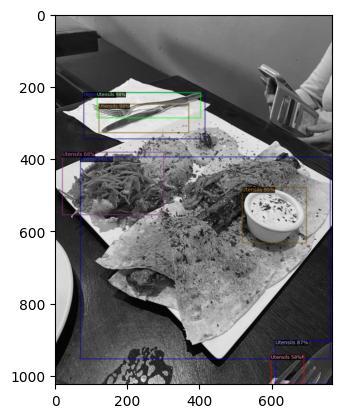

MergeDataset/IMG_1854.JPG


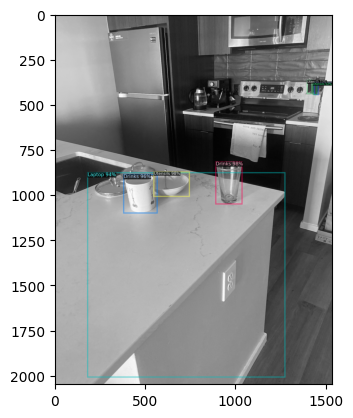

MergeDataset/IMG_9074.jpg


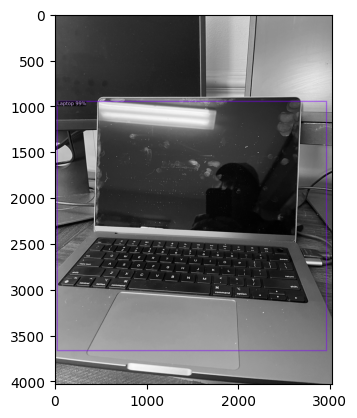

MergeDataset/A6E34312-6B3D-462F-8E98-8BF657064F9E_1_105_c.jpeg


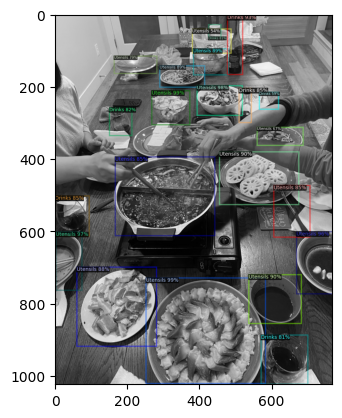

MergeDataset/64969884071__D0CD84FF-D370-4335-A402-77A8CF56896A.jpg


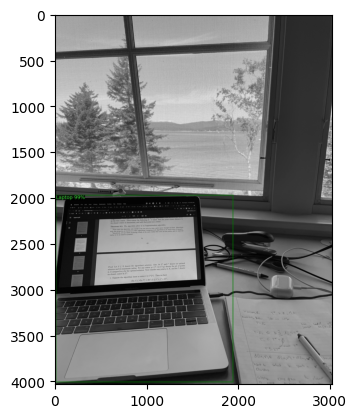

MergeDataset/20210923_134958.jpg


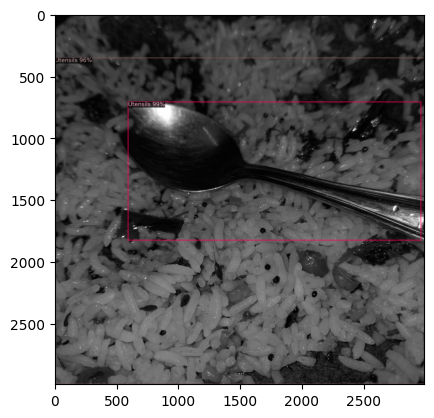

MergeDataset/1A8C4D6C-1191-494E-AB54-74156D929962_1_105_c.jpeg


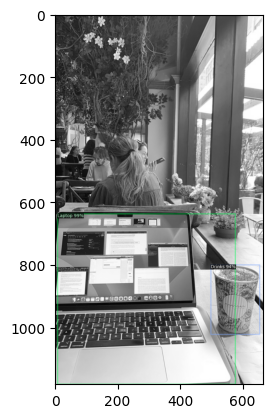

MergeDataset/IMG_1855.JPG


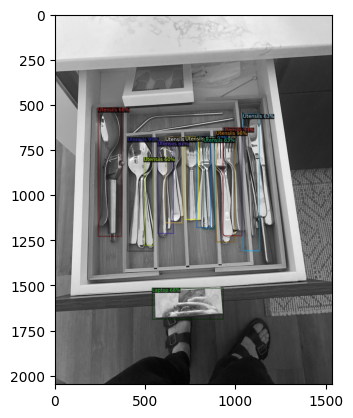

MergeDataset/20CA32A6-E77C-4F03-A4F2-6F9392123017_1_105_c.jpeg


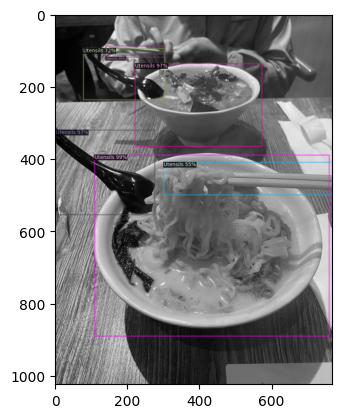

MergeDataset/IMG_8843.jpg


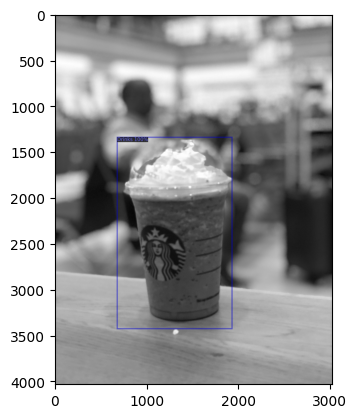

MergeDataset/IMG_4940.JPG


KeyboardInterrupt: 

In [13]:
from detectron2.utils.visualizer import ColorMode

sample_metadata = MetadataCatalog.get("test_dataset")
dataset_dicts = DatasetCatalog.get("test_dataset")

for d in random.sample(dataset_dicts, 30):    
    im = cv2.imread(d["file_name"])
    print(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # cv2_imshow(v.get_image()[:, :, ::-1])
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine import DefaultPredictor
import random

# Initialize confusion matrix
num_classes = len(MetadataCatalog.get("test_dataset").thing_classes)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Perform inference
predictor = DefaultPredictor(cfg)
sample_metadata = MetadataCatalog.get("test_dataset")
dataset_dicts = DatasetCatalog.get("test_dataset")

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    # Process predictions
    v = Visualizer(im[:, :, ::-1], metadata=sample_metadata, scale=1, instance_mode=ColorMode.IMAGE_BW)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
    # Update confusion matrix
    for i in range(len(outputs["instances"])):
        pred_cls = outputs["instances"].pred_classes[i].item()
        # Assuming ground truth annotations are available in dataset_dicts
        gt_cls = d["annotations"][i]["category_id"]
        conf_matrix[gt_cls, pred_cls] += 1

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


MergeDataset/IMG_4940.JPG


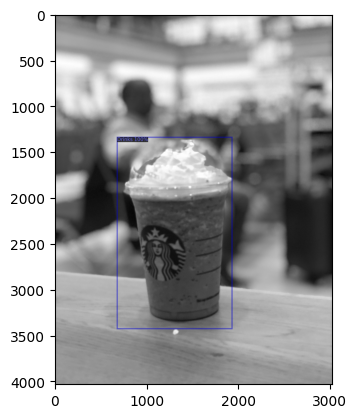

In [15]:
im = cv2.imread('MergeDataset/IMG_8843.jpg')
print(d["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=sample_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(v.get_image()[:, :, ::-1])
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()